In [81]:
! pip3 install scipy


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


# Libraries

In [82]:
! pip3 install catboost


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [83]:
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from catboost import CatBoostRegressor
from sklearn.model_selection import GridSearchCV
from datetime import datetime
import matplotlib.patches as mpatches

# Import datasets

In [84]:
df = pd.read_csv('Train.csv')
df_test = pd.read_csv('Test.csv')

In [85]:
df.head()

ID       DATOP     FLTID DEPSTN ARRSTN                  STD  \
0  train_id_0  2016-01-03  TU 0712     CMN    TUN  2016-01-03 10:30:00   
1  train_id_1  2016-01-13  TU 0757     MXP    TUN  2016-01-13 15:05:00   
2  train_id_2  2016-01-16  TU 0214     TUN    IST  2016-01-16 04:10:00   
3  train_id_3  2016-01-17  TU 0480     DJE    NTE  2016-01-17 14:10:00   
4  train_id_4  2016-01-17  TU 0338     TUN    ALG  2016-01-17 14:30:00   

                   STA STATUS         AC  target  
0  2016-01-03 12.55.00    ATA  TU 32AIMN   260.0  
1  2016-01-13 16.55.00    ATA  TU 31BIMO    20.0  
2  2016-01-16 06.45.00    ATA  TU 32AIMN     0.0  
3  2016-01-17 17.00.00    ATA  TU 736IOK     0.0  
4  2016-01-17 15.50.00    ATA  TU 320IMU    22.0

DATOP - Date of flight

FLTID - Flight number

DEPSTN - Departure point

ARRSTN - Arrival point

STD - Scheduled Time departure

STA - Scheduled Time arrival

STATUS - Flight status

AC - Aircraft Code

# Data Visualization

In [86]:
df.shape


(107833, 10)

In [87]:
df_test.shape

(9333, 9)

In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 10 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      107833 non-null  object 
 1   DATOP   107833 non-null  object 
 2   FLTID   107833 non-null  object 
 3   DEPSTN  107833 non-null  object 
 4   ARRSTN  107833 non-null  object 
 5   STD     107833 non-null  object 
 6   STA     107833 non-null  object 
 7   STATUS  107833 non-null  object 
 8   AC      107833 non-null  object 
 9   target  107833 non-null  float64
dtypes: float64(1), object(9)
memory usage: 8.2+ MB


We don't have missing values



In [89]:
df.describe()

target
count  107833.000000
mean       48.733013
std       117.135562
min         0.000000
25%         0.000000
50%        14.000000
75%        43.000000
max      3451.000000

In [90]:
! pip3 install dataprep


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [91]:
df['STD'] =  pd.to_datetime(df['STD'], format='%Y-%m-%d %H:%M:%S')
df['STA'] =  pd.to_datetime(df['STA'], format='%Y-%m-%d %H.%M.%S')
df['DATOP'] =  pd.to_datetime(df['DATOP'], format='%Y-%m-%d')

df_test['STD'] =  pd.to_datetime(df_test['STD'], format='%Y-%m-%d %H:%M:%S')
df_test['STA'] =  pd.to_datetime(df_test['STA'], format='%Y-%m-%d %H.%M.%S')
df_test['DATOP'] =  pd.to_datetime(df_test['DATOP'], format='%Y-%m-%d')

In [92]:
# there is a space after the flight id
df['FLTID'] = df['FLTID'].astype(str).str[:-1]
df_test['FLTID'] = df_test['FLTID'].astype(str).str[:-1]

In [93]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0  
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0  
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0  
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0  
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0

In [94]:
df['STATUS'].unique()

array(['ATA', 'DEP', 'RTR', 'SCH', 'DEL'], dtype=object)

In [95]:
df['AC'].unique()

array(['TU 32AIMN', 'TU 31BIMO', 'TU 736IOK', 'TU 320IMU', 'TU 736IOP',
       'TU 32AIMH', 'TU 32AIMI', 'TU 32AIMC', 'TU 31AIMK', 'TU 32AIMF',
       'TU 32AIMP', 'TU 320IMR', 'TU 332IFN', 'TU 31AIMJ', 'TU 320IMT',
       'TU 736IOL', 'TU 31BIMQ', 'TU 736IOR', 'TU 320IMV', 'TU 320IMS',
       'TU 332IFM', 'TU 320IMW', 'TU 32AIML', 'TU 32AIMD', 'TU 32AIMM',
       'TU CR9ISA', 'TU 32AIMG', 'TU 736ION', 'TU 736IOM', 'TU 736IOQ',
       '5M 343SUN', 'UG AT7LBD', '5K 343TQY', 'UG AT7LBE', 'UG AT7AT7',
       'BJ 320INP', 'BJ 320INH', 'BJ 320INQ', 'BJ 320INA', 'UG CR9XXX',
       'UG CR9CR9', 'TU 32A32A', 'BJ 320INB', 'GJ 734CGC', 'QS 738TSC',
       'PS 738PSD', 'D4 319CQG', 'BJ 320INR', 'BJ 320INC', 'UJ 320TCF',
       '5K 345TFX', 'D4 320CQP', '5M 343JAI', 'GW 320MQH', 'UG CR9ISA',
       '6P M87TRJ', 'TU CR9CR9', 'TU CR9XXX', 'GJ 733EWE', 'GJ 734PGC',
       'GJ 733GGC', 'GJ 734MGC', 'GJ 733LGC', '5M 343FOX', 'BJ 320INO',
       'OL 321ABY', 'X9 320VEB', 'TU 320320'], dtype=object)

## Target analysis

In [96]:
df['target'].mean()


48.73301308504818

In [97]:
# function that extract statistical parameters from a grouby objet:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['target'].groupby(df['AC']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')
global_stats

min     max   count        mean
AC                                        
TU 320320  0.0     0.0     1.0    0.000000
TU CR9XXX  0.0     0.0     2.0    0.000000
TU 32A32A  0.0     0.0     2.0    0.000000
OL 321ABY  0.0   302.0     5.0  205.400000
TU CR9CR9  0.0     0.0     6.0    0.000000
...        ...     ...     ...         ...
TU 320IMV  0.0  2042.0  4589.0   56.915232
TU 320IMR  0.0  1890.0  4601.0   58.260378
TU 320IMT  0.0  2835.0  4634.0   58.406129
TU 320IMW  0.0  2745.0  4685.0   61.432444
TU 320IMU  0.0  3317.0  4724.0   58.867697

[68 rows x 4 columns]

In [98]:
global_stats.sort_values('max')


min     max   count       mean
AC                                       
TU 320320  0.0     0.0     1.0   0.000000
UG CR9CR9  0.0     0.0    30.0   0.000000
UG AT7AT7  0.0     0.0  1441.0   0.000000
TU CR9CR9  0.0     0.0     6.0   0.000000
UG CR9XXX  0.0     0.0    80.0   0.000000
...        ...     ...     ...        ...
TU 320IMS  0.0  2942.0  4214.0  57.329616
TU 736IOQ  0.0  2980.0  3072.0  39.202474
TU 32AIML  0.0  3245.0  4122.0  61.064774
TU 320IMU  0.0  3317.0  4724.0  58.867697
TU 32AIMM  0.0  3451.0  2632.0  63.453267

[68 rows x 4 columns]

### Number of flights per company

(-1.099999999930318,
 1.0999999999966819,
 -1.0999999998411332,
 1.0999999999924328)

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

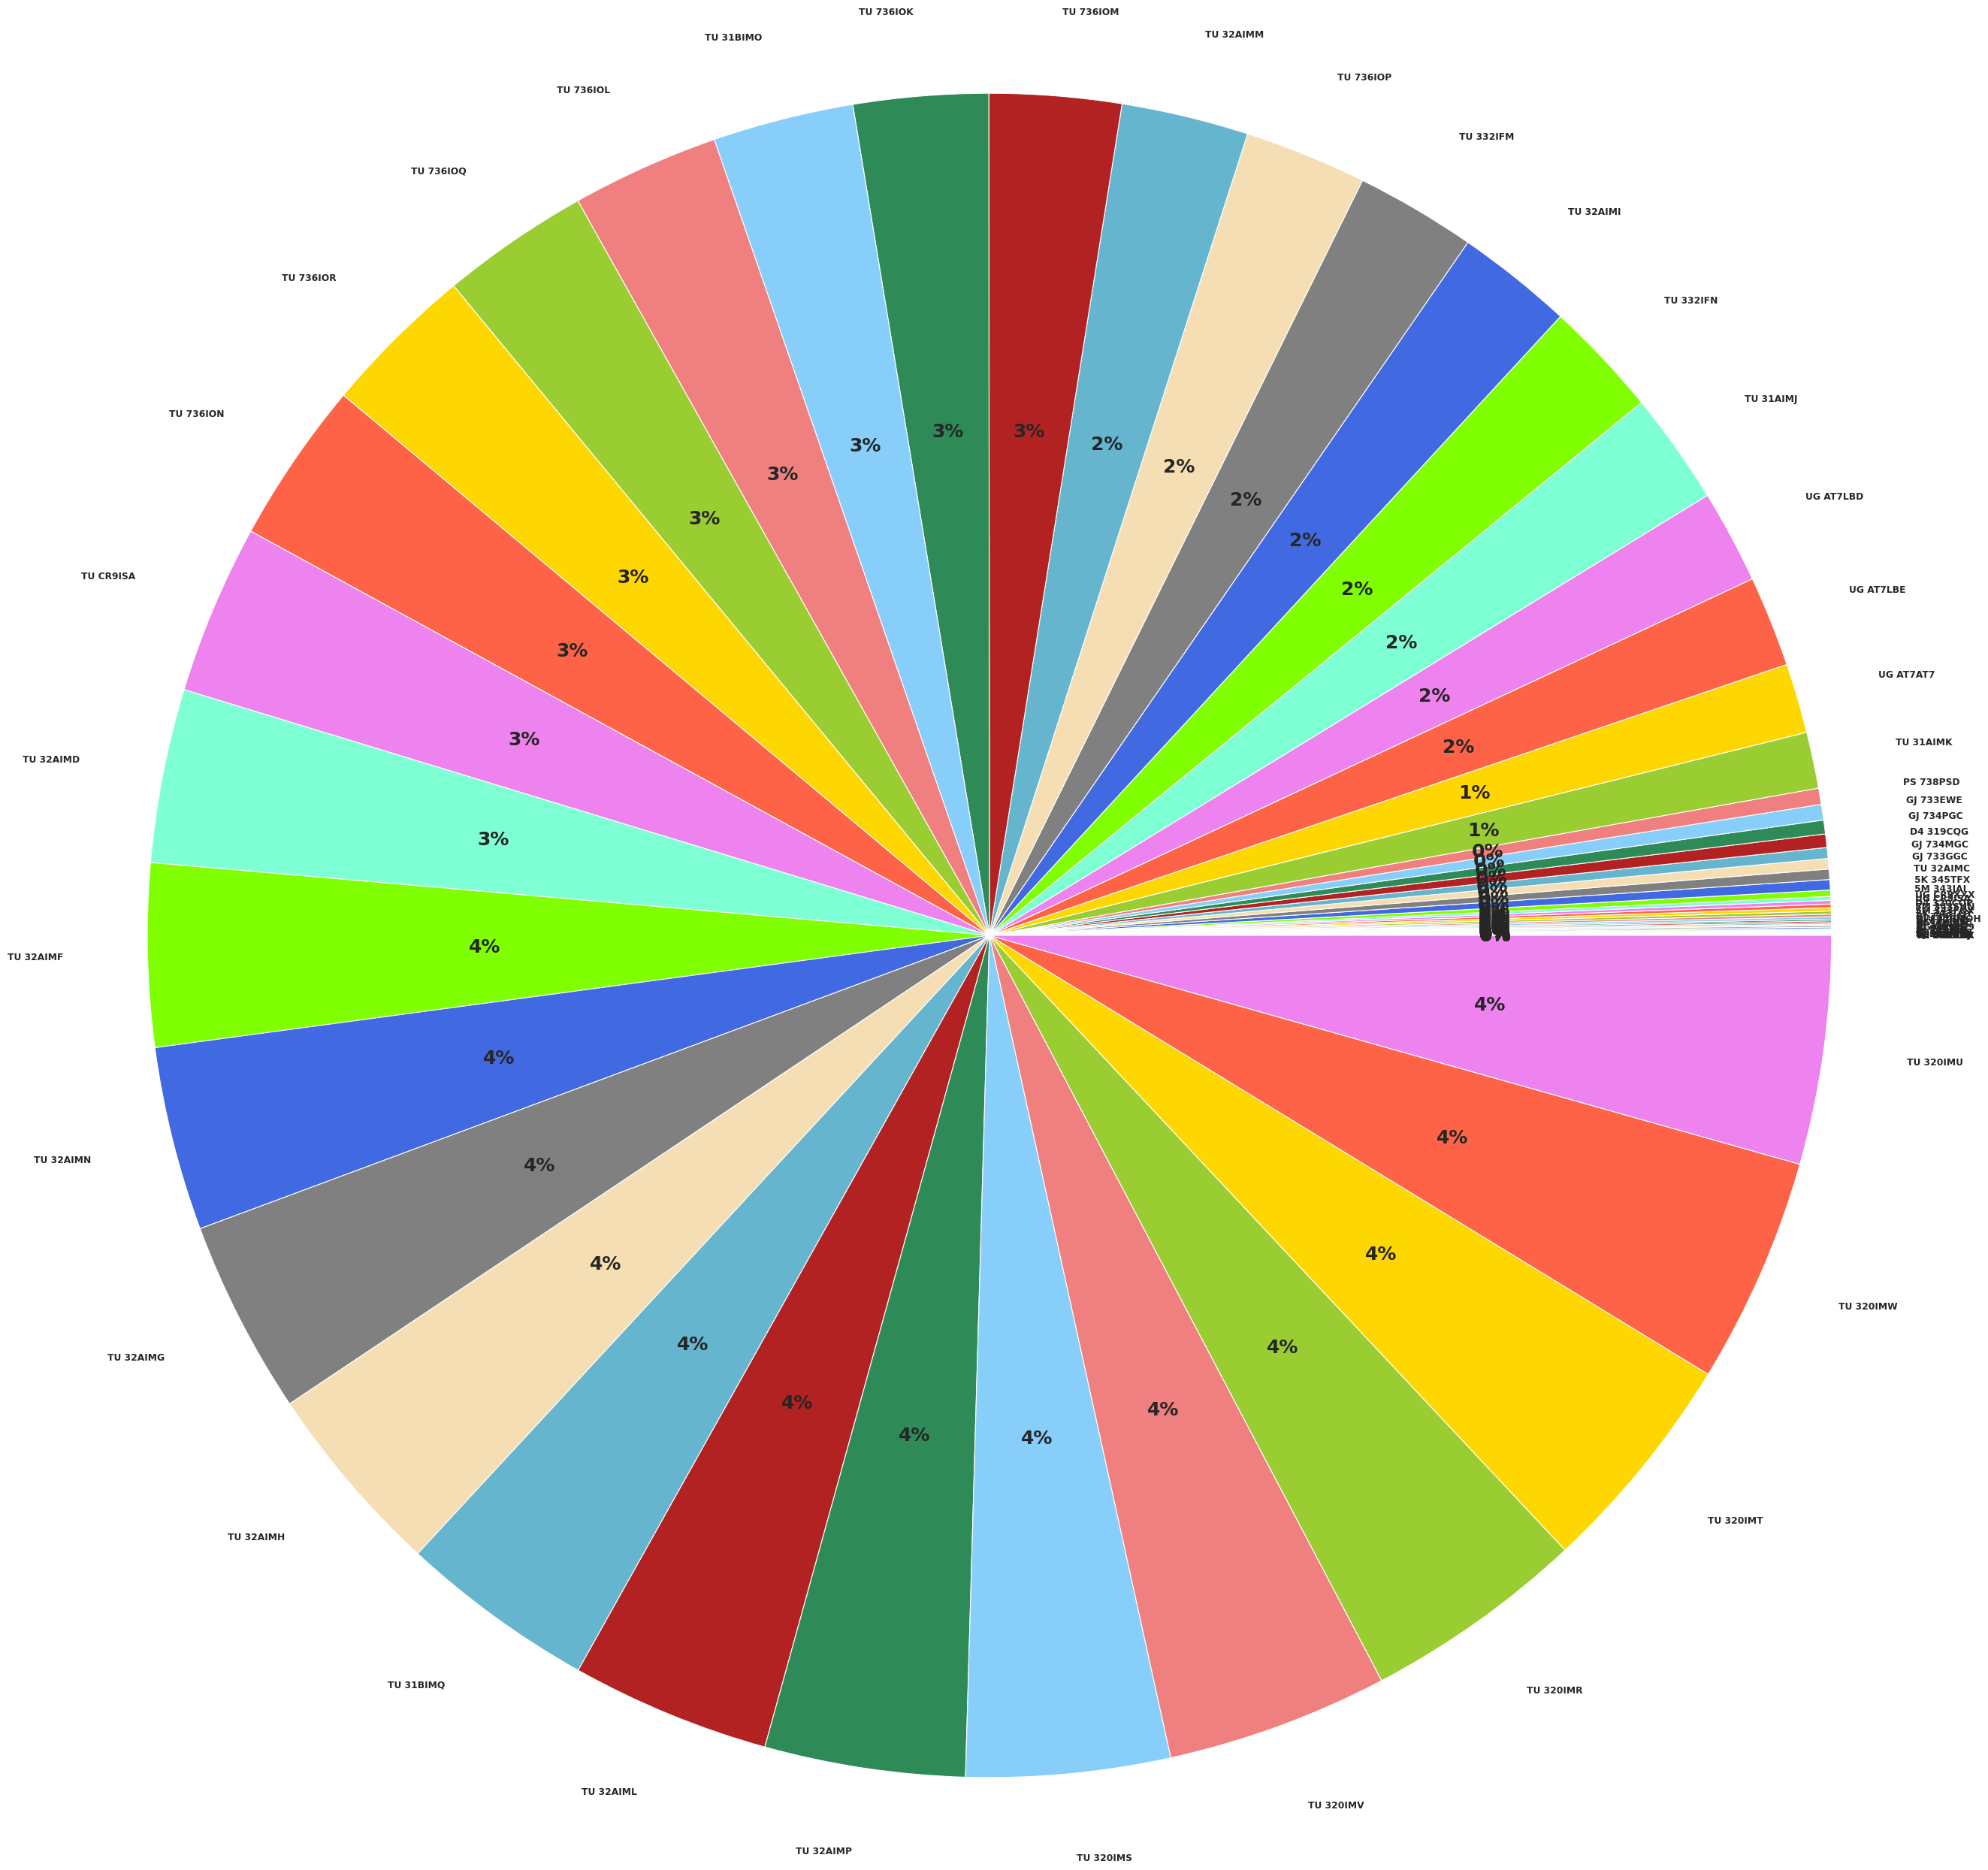

In [99]:
font = {'family' : 'normal', 'weight' : 'bold', 'size'   : 18}
mpl.rc('font', **font)

df2 = df.loc[:, ['AC', 'target']]
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
  
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']

fig = plt.figure(1, figsize=(70,70))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
# Pie chart nº1: nb of flights
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
explode = [0.3 if sizes[i] < 1.0 else 0.0 for i in range(len(sizes))]
patches, texts, autotexts = ax1.pie(sizes, explode=explode,
                                labels=labels, colors = colors,  autopct='%1.0f%%',
                                shadow=False, startangle=0)
ax1.axis('equal')

### Mean delay at departure

findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

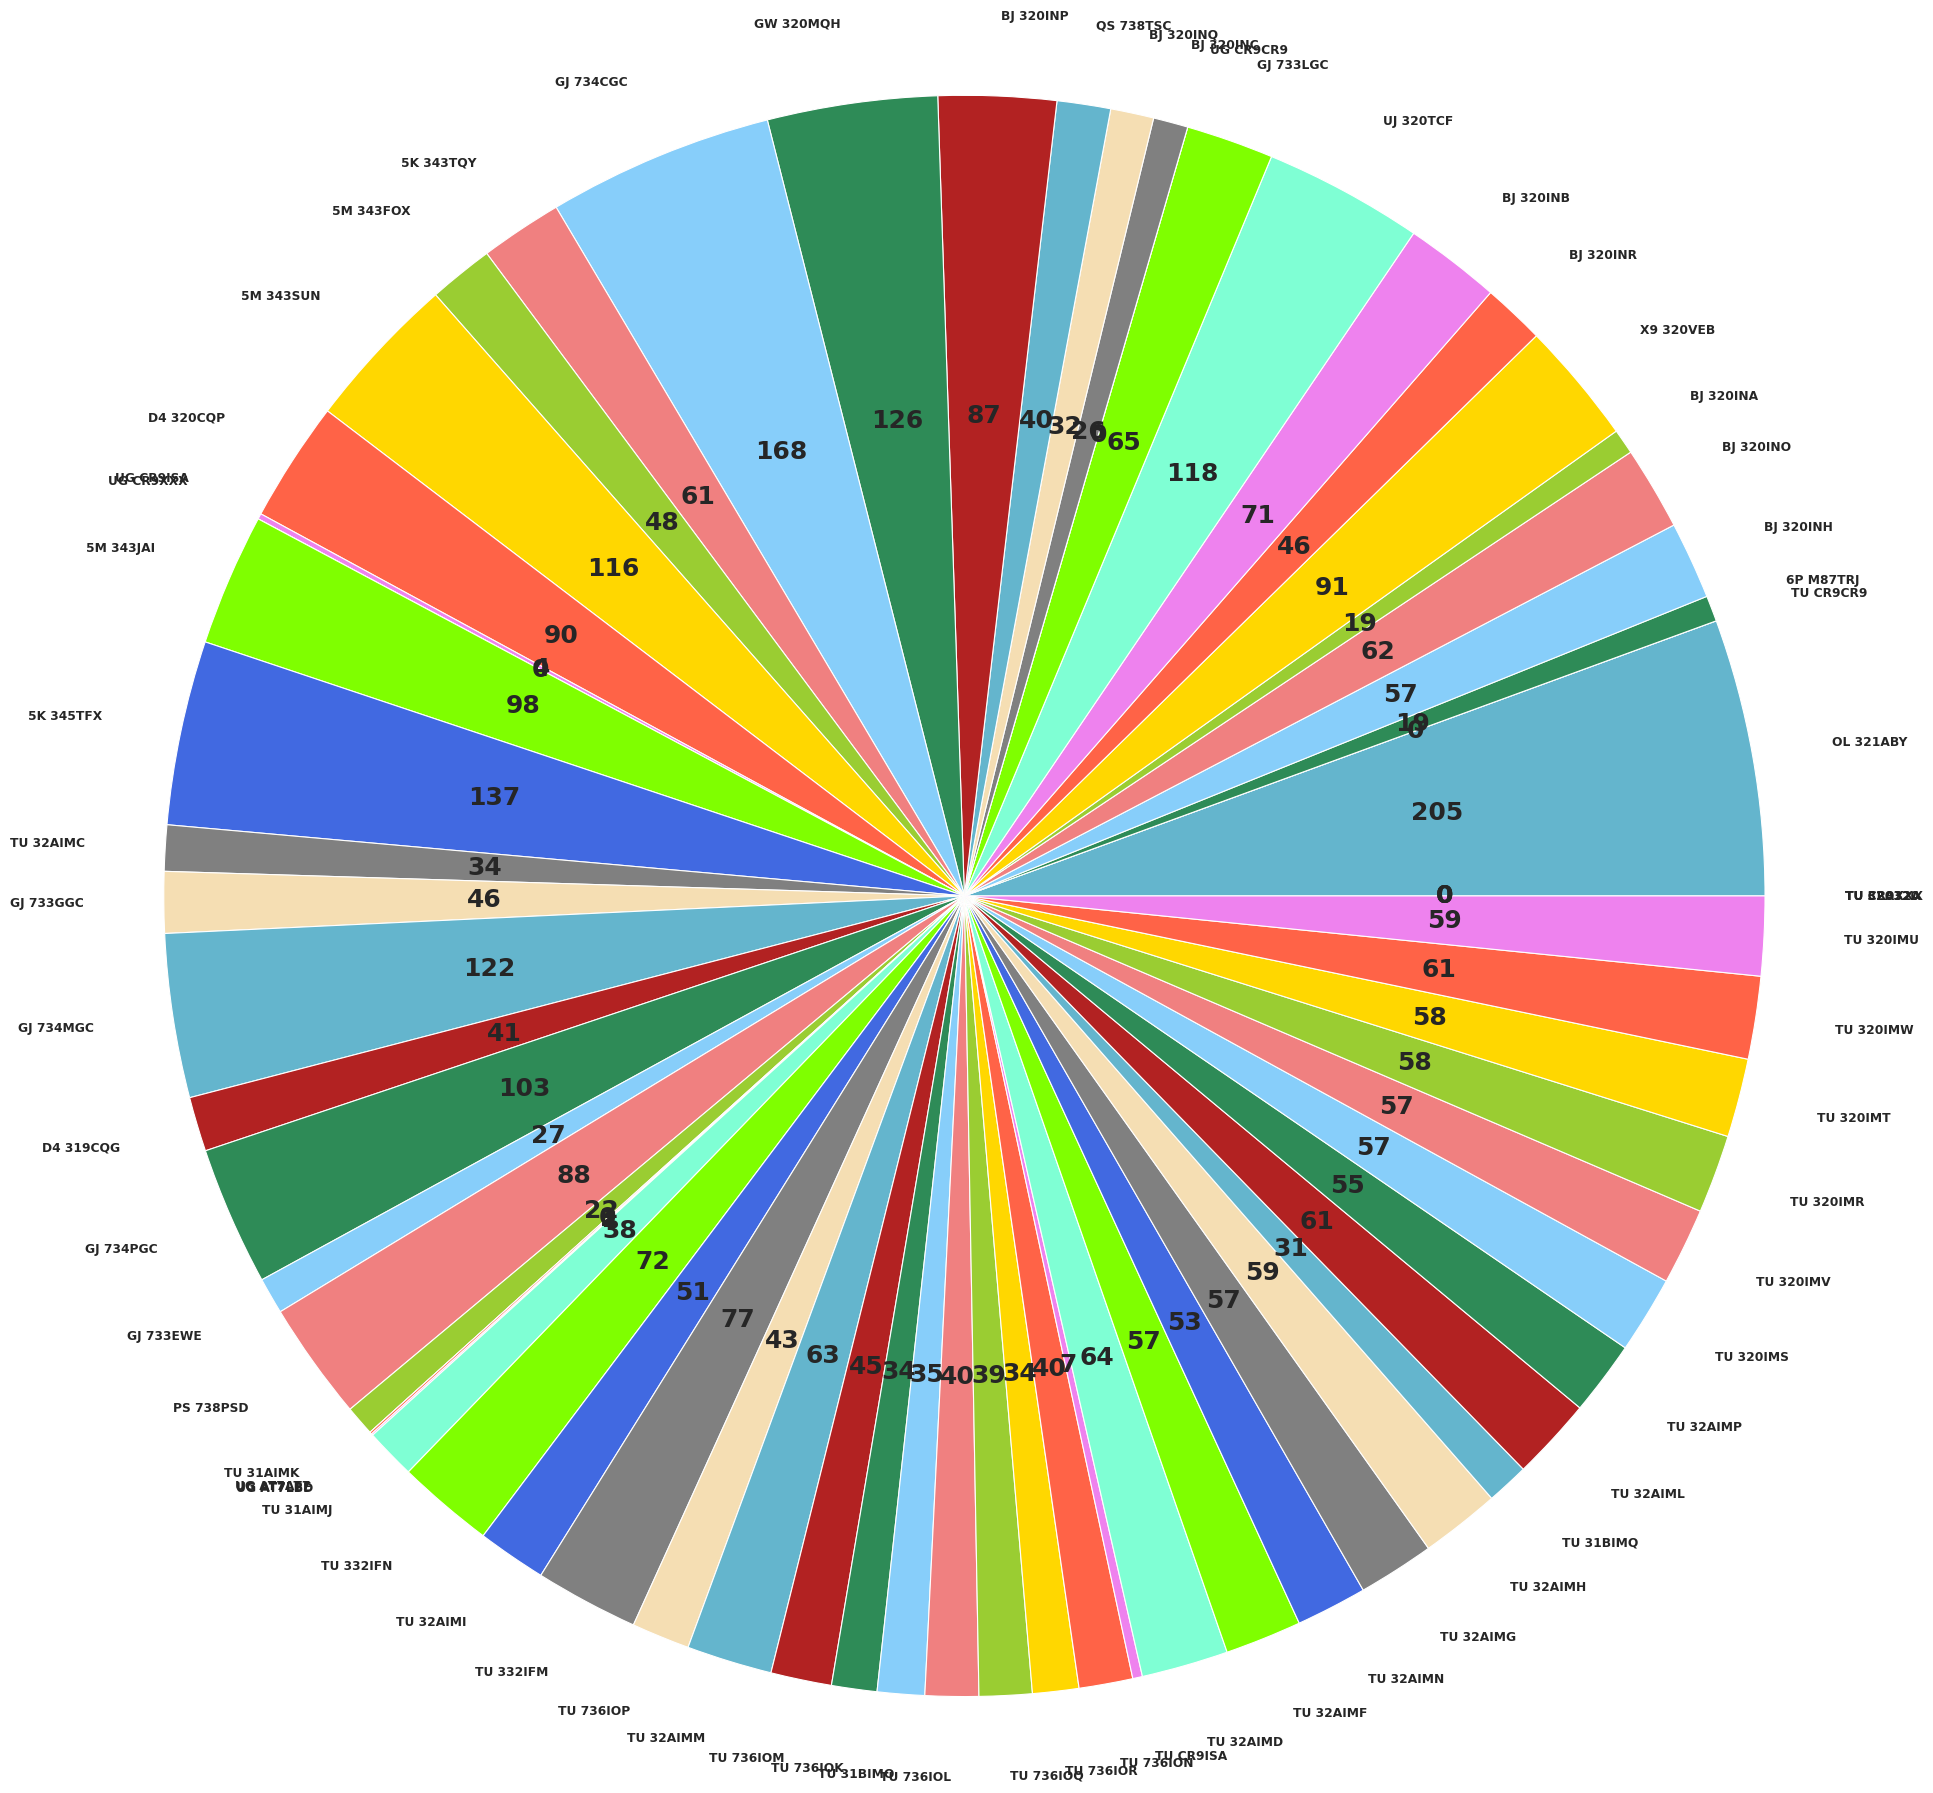

In [100]:
fig = plt.figure(1, figsize=(50,50))
ax2=fig.add_subplot(gs[0,0])
labels = [s for s in  global_stats.index]
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]
patches, texts, autotexts = ax2.pie(sizes, labels = labels,
                                colors = colors, shadow=False, startangle=0,
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
ax2.axis('equal')
plt.show()

### Departure delay

In [101]:
import plotly.express as px

df2 = df.loc[:, ['AC', 'target']]
df2 = df2.drop(df2[df2.target == 0].index)

fig = px.strip(df2, x="target", y="AC", hover_data=df2.columns,
               labels={"target": "Departure delay", "AC": "AC"},
               width=800, height=800)

fig.update_traces(marker=dict(size=12, line=dict(width=2)),
                  jitter=0.3, hoverinfo="text")

fig.update_layout(
    xaxis=dict(title=dict(text="Departure delay"), tickmode='linear'),
    yaxis=dict(visible=False),
    showlegend=False,
    title="Strip Plot",
    title_x=0.5,
    margin=dict(t=100),
)

fig.show()


findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not found.
findfont: Font family 'normal' not

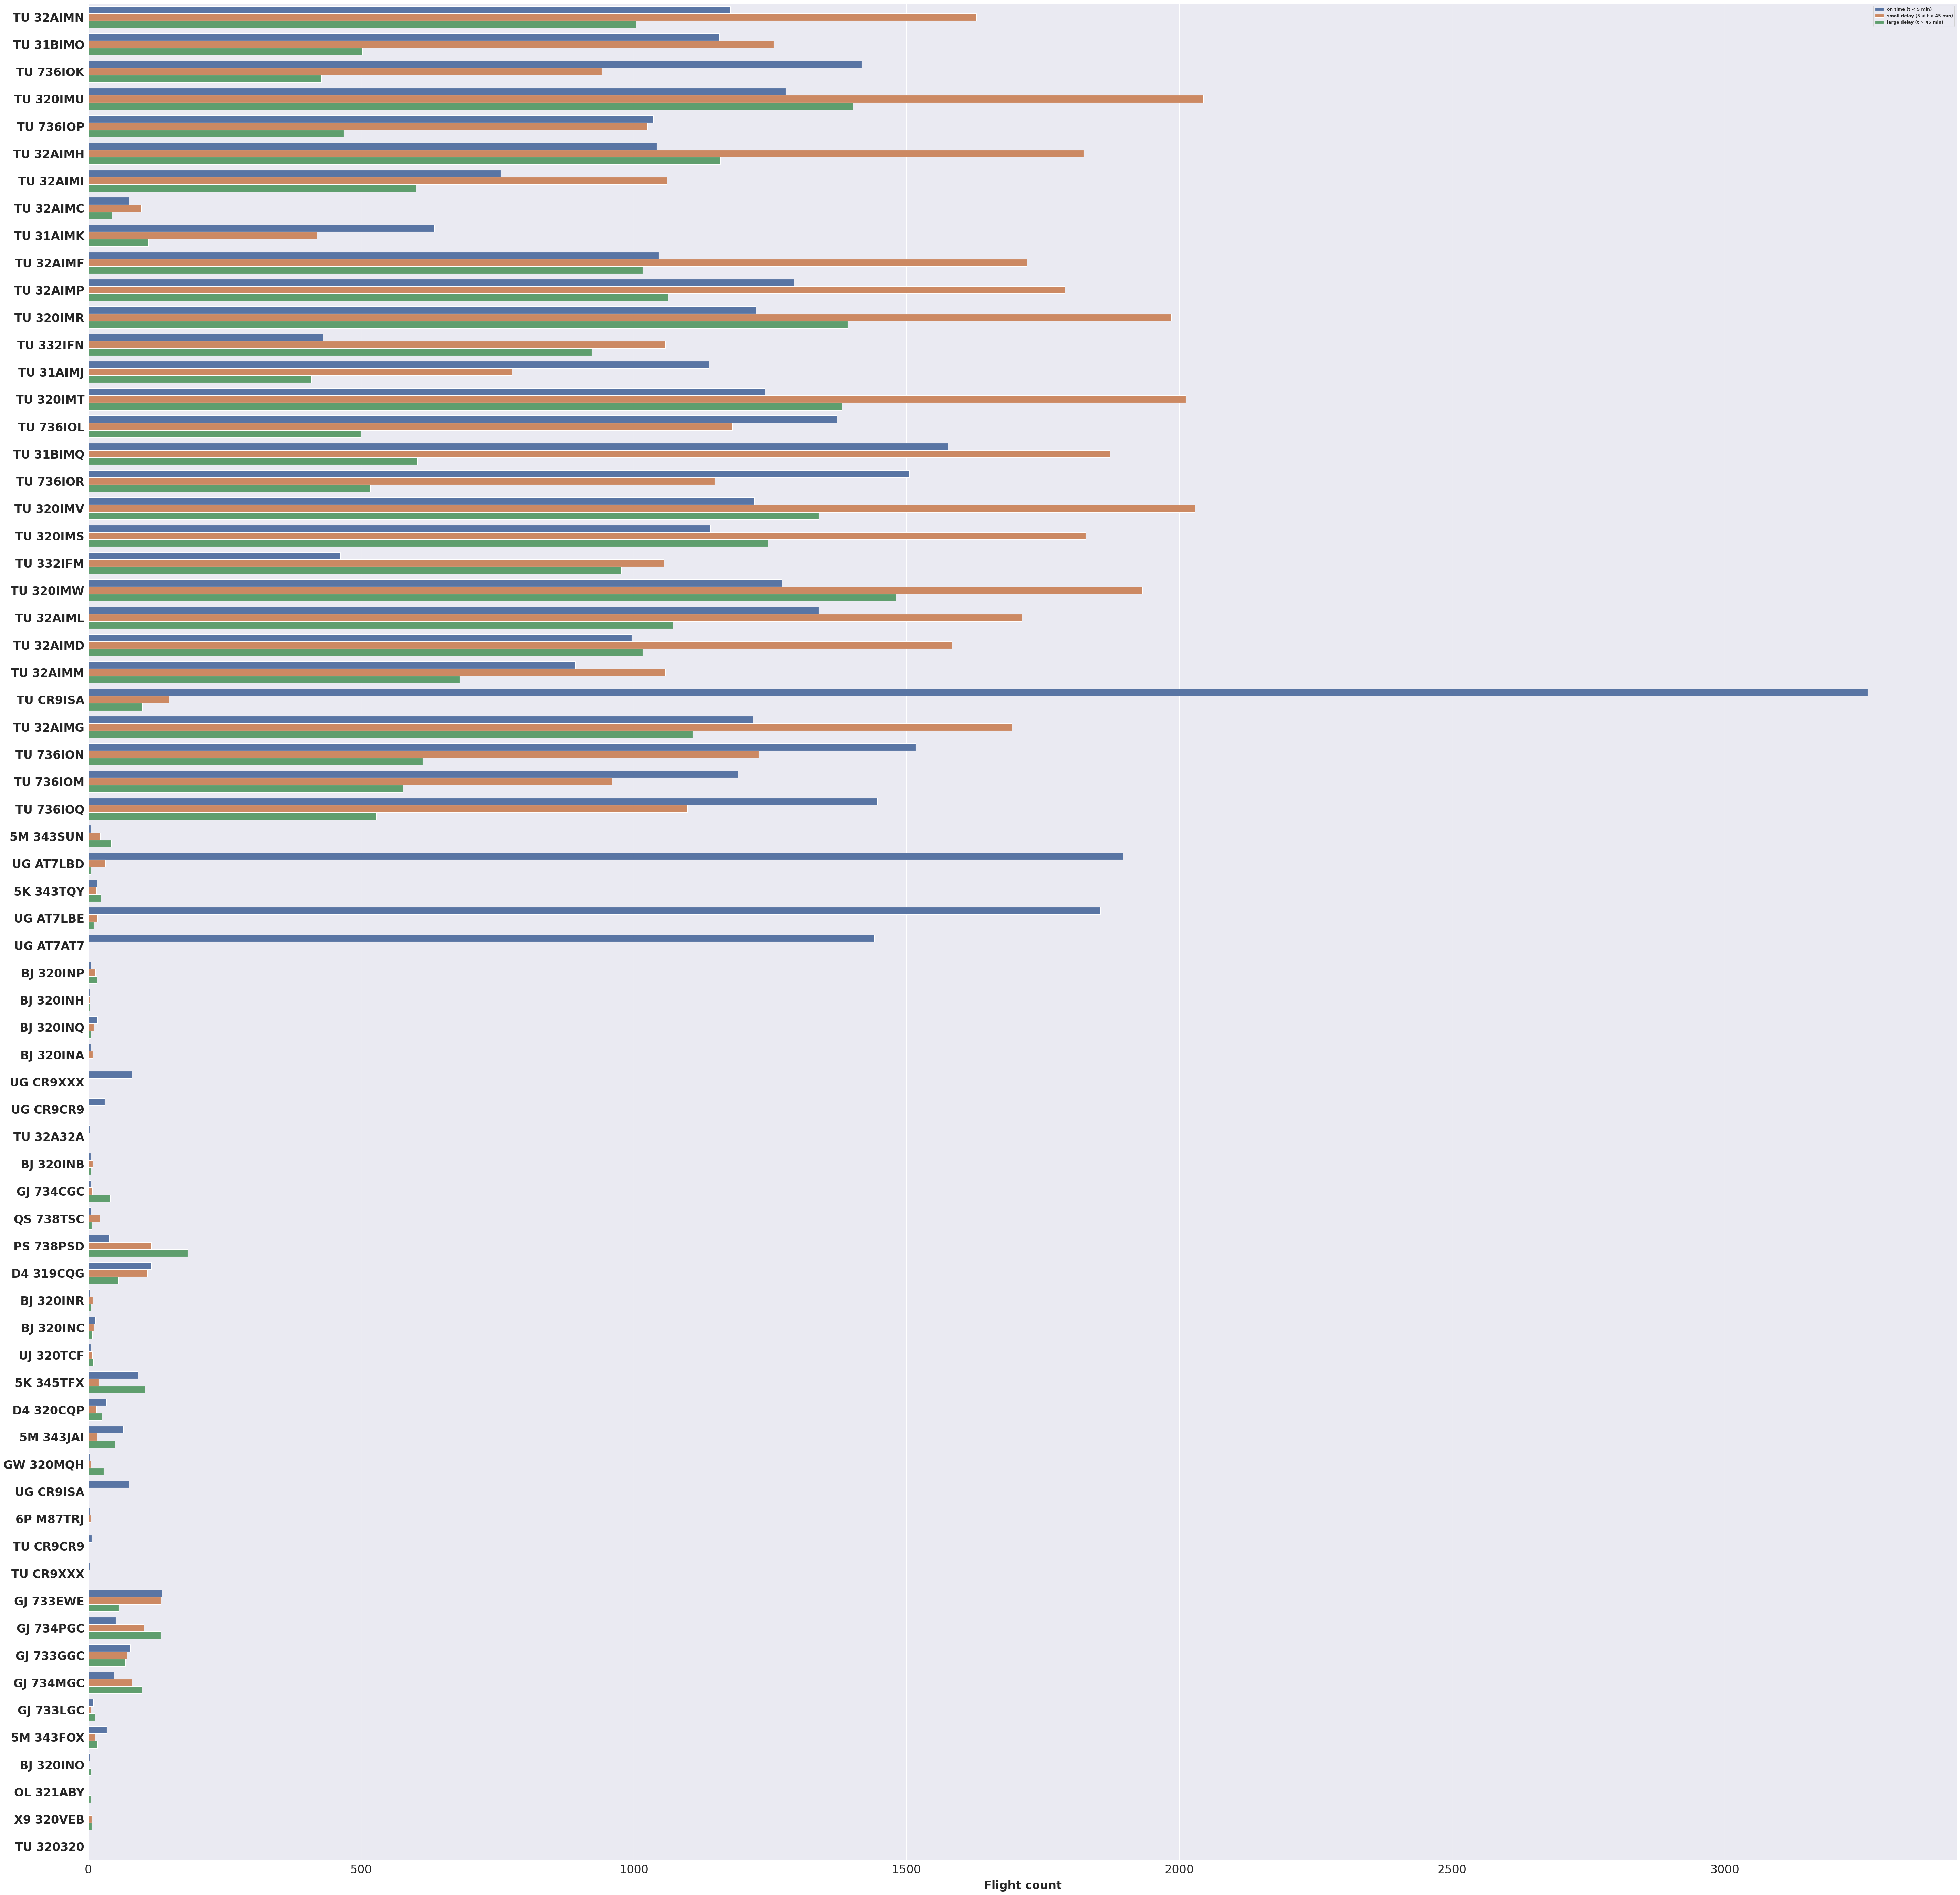

In [102]:
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['target'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(70,70))
ax = sns.countplot(y="AC", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = df['AC'].unique().tolist()
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=24, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=24, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=24, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

## Relationship between the origin airport and delays

In [103]:
print("Nb of airports: {}".format(len(df['DEPSTN'].unique())))

Nb of airports: 132


In [104]:
list_of_airpots = df['DEPSTN'].unique().tolist()
list_of_ac = df['AC'].unique().tolist()
origin_nb = dict()
for carrier in list_of_ac:
    liste_origin_airport = df[df['AC'] == carrier]['DEPSTN'].unique().tolist()
    origin_nb[carrier] = len(liste_origin_airport)

In [105]:
import plotly.graph_objects as go

test_df = pd.DataFrame.from_dict(origin_nb, orient='index')
test_df.rename(columns={0: 'count'}, inplace=True)

fig = go.Figure(data=[go.Bar(x=test_df.index, y=test_df['count'])])

fig.update_layout(
    xaxis=dict(title=dict(text="Airports"), tickangle=80),
    yaxis=dict(title=dict(text="Number of airports visited")),
    title="Number of Airports Visited",
    title_x=0.5,
    showlegend=False,
    margin=dict(t=100),
)

fig.show()


### number of flights per year



In [106]:
df['year'] = pd.DatetimeIndex(df['DATOP']).year
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  DELAY_LEVEL  year  
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0            2  2016  
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0            1  2016  
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0            0  2016  
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0            0  2016  
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0            1  2016

In [107]:
flights_dict = dict()
ac_group = df.groupby('AC')
for x in list_of_ac:
    df_ac = ac_group.get_group(x)
    flights_dict[x] = df[df['AC'] == x]['year'].value_counts().to_dict()
print(flights_dict)

{'TU 32AIMN': {2018: 1569, 2017: 1264, 2016: 976}, 'TU 31BIMO': {2016: 1265, 2018: 1125, 2017: 525}, 'TU 736IOK': {2018: 1363, 2016: 1316, 2017: 107}, 'TU 320IMU': {2018: 1644, 2017: 1602, 2016: 1478}, 'TU 736IOP': {2017: 1376, 2016: 1065, 2018: 88}, 'TU 32AIMH': {2017: 1575, 2018: 1469, 2016: 982}, 'TU 32AIMI': {2016: 1290, 2018: 999, 2017: 129}, 'TU 32AIMC': {2016: 213, 2017: 1, 2018: 1}, 'TU 31AIMK': {2016: 1081, 2017: 81, 2018: 1}, 'TU 32AIMF': {2018: 1441, 2016: 1322, 2017: 1020}, 'TU 32AIMP': {2017: 1580, 2018: 1412, 2016: 1154}, 'TU 320IMR': {2017: 1643, 2018: 1620, 2016: 1338}, 'TU 332IFN': {2018: 903, 2017: 811, 2016: 697}, 'TU 31AIMJ': {2017: 1212, 2016: 1110, 2018: 2}, 'TU 320IMT': {2017: 1638, 2018: 1554, 2016: 1442}, 'TU 736IOL': {2018: 1198, 2017: 1006, 2016: 847}, 'TU 31BIMQ': {2018: 1490, 2016: 1296, 2017: 1266}, 'TU 736IOR': {2018: 1160, 2016: 1104, 2017: 906}, 'TU 320IMV': {2018: 1610, 2017: 1563, 2016: 1416}, 'TU 320IMS': {2016: 1461, 2017: 1410, 2018: 1343}, 'TU 332

In [108]:
# flights_dict
nbr_flights = pd.DataFrame.from_dict(flights_dict, orient='index')
nbr_flights.fillna(0, inplace=True)
# nbr_flights
nbr_flights.columns = ['flights_in_2018', 'flights_in_2017', 'flights_in_2016']
nbr_flights['flights_in_2016'] = nbr_flights['flights_in_2016'].astype(np.int64)
nbr_flights['flights_in_2017'] = nbr_flights['flights_in_2017'].astype(np.int64)
nbr_flights['flights_in_2018'] = nbr_flights['flights_in_2018'].astype(np.int64)
nbr_flights['total_flights'] = nbr_flights['flights_in_2016'] + nbr_flights['flights_in_2017'] + nbr_flights['flights_in_2018']
# nbr_flights
print("* Total Flights")
print("- Min :")
print(nbr_flights['total_flights'].unique().min())
print("- Max :")
print(nbr_flights['total_flights'].unique().max())
print("* flights in 2018")
print("- Unique :")
print(nbr_flights['flights_in_2018'].unique())


* Total Flights
- Min :
1
- Max :
4724
* flights in 2018
- Unique :
[1569 1125 1363 1644   88 1469  999    1 1441 1412 1620  903    2 1554
 1198 1490 1160 1610 1343  958 1513 1450  399 1529 1432 1176 1226 1391
  466  314  346    4    6   37   12   73  324  285  216  225   25   63
    8    5   13    0]


### Describing the frequency of AC

Add a variable describing the frequency of that AC's flights 3 levels (100 <, 100< < 200, >200)  per year


In [109]:
df['ac_frequency'] = 0
def define_frequency(nbr):
        if nbr<100:
            return 0
        
        else:
            if (nbr>100 and nbr<200): 
                return 1
            else:
                return 2

In [110]:
for i in range(df.shape[0]):
    ac = df.loc[i, 'AC']
    year = df.loc[i, 'year']
    if year == 2016:
        freq_2016 = define_frequency(nbr_flights.loc[ac, 'flights_in_2016'])
        if freq_2016 !=0:
            df.at[i, 'ac_frequency'] = freq_2016
    else:
        if year == 2017:
            freq_2017 = define_frequency(nbr_flights.loc[ac, 'flights_in_2017'])
            if freq_2017 !=0:
                df.at[i, 'ac_frequency'] = freq_2017
        else:
            freq_2018 = define_frequency(nbr_flights.loc[ac, 'flights_in_2018'])
            if freq_2018 !=0:
                df.at[i, 'ac_frequency'] = freq_2018

In [111]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  DELAY_LEVEL  year  \
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0            2  2016   
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0            1  2016   
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0            0  2016   
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0            0  2016   
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0            1  2016   

   ac_frequency  
0             2  
1             2  
2             2  
3             2  
4             2

## Airport mean delays

In [112]:
airport_mean_delays = pd.DataFrame(pd.Series(df['DEPSTN'].unique()))
airport_mean_delays.set_index(0, drop = True, inplace = True)

for carrier in list_of_ac:
    df1 = df[df['AC'] == carrier]
    test = df1['target'].groupby(df['DEPSTN']).apply(get_stats).unstack()
    airport_mean_delays[carrier] = test.loc[:, 'mean'] 


In [113]:
airport_mean_delays

TU 32AIMN   TU 31BIMO  TU 736IOK   TU 320IMU  TU 736IOP  TU 32AIMH  \
0                                                                         
CMN  85.260870   50.381579   9.000000   38.070707  44.666667  71.457627   
MXP  72.928571   26.992248  63.384615   62.860465  57.235294  50.710526   
TUN  49.942475   28.700662  30.389868   49.561247  43.560468  51.437832   
DJE  30.598870  226.375000  27.783333   90.250000  32.969359  45.094340   
TLS  78.642857   51.259259  37.857143  100.208333  68.397590  60.269231   
..         ...         ...        ...         ...        ...        ...   
KRR        NaN         NaN        NaN         NaN        NaN        NaN   
RTM        NaN         NaN        NaN         NaN        NaN        NaN   
STR        NaN         NaN        NaN         NaN        NaN        NaN   
TPS        NaN         NaN        NaN         NaN        NaN        NaN   
CTA        NaN         NaN        NaN         NaN        NaN        NaN   

     TU 32AIMI   TU 32AIMC  TU 31AIMK   TU 32AIMF  ...  GJ 733EWE   GJ 734PGC  \
0                                                  ...                          
CMN  47.586207   28.000000        NaN   67.052632  ...        NaN         NaN   
MXP  43.166667   41.800000  23.333333   53.523256  ...        NaN   79.250000   
TUN  43.657443   23.869565  23.066667   50.034404  ...        NaN  138.301370   
DJE  59.439716  101.000000  14.707547   48.873494  ...   16.56129  200.000000   
TLS  48.857143   41.000000  42.666667   65.114286  ...        NaN  111.727273   
..         ...         ...        ...         ...  ...        ...         ...   
KRR        NaN         NaN        NaN         NaN  ...        NaN         NaN   
RTM        NaN         NaN        NaN  250.000000  ...        NaN         NaN   
STR        NaN         NaN        NaN         NaN  ...        NaN         NaN   
TPS        NaN         NaN        NaN         NaN  ...        NaN         NaN   
CTA        NaN         NaN        NaN         NaN  ...        NaN         NaN   

     GJ 733GGC   GJ 734MGC  GJ 733LGC  5M 343FOX  BJ 320INO  OL 321ABY  \
0                                                                        
CMN        NaN         NaN        NaN        NaN        NaN        NaN   
MXP        NaN   50.000000        NaN        NaN        NaN        NaN   
TUN      112.0  141.666667        NaN  56.764706       47.5      232.5   
DJE       31.0  623.750000  45.461538   0.000000        NaN        NaN   
TLS        NaN   50.000000        NaN        NaN        NaN      260.0   
..         ...         ...        ...        ...        ...        ...   
KRR        NaN         NaN        NaN        NaN        NaN        NaN   
RTM        NaN         NaN        NaN        NaN        NaN        NaN   
STR        NaN         NaN        NaN        NaN        NaN        NaN   
TPS        NaN         NaN        NaN        NaN        NaN        NaN   
CTA        NaN         NaN        NaN        NaN        NaN        NaN   

     X9 320VEB  TU 320320  
0                          
CMN        NaN        NaN  
MXP        NaN        NaN  
TUN       83.5        0.0  
DJE        NaN        NaN  
TLS        NaN        NaN  
..         ...        ...  
KRR        NaN        NaN  
RTM        NaN        NaN  
STR        0.0        NaN  
TPS        NaN        NaN  
CTA        NaN        NaN  

[132 rows x 68 columns]

The code aims to visualize the average delays using heatmaps, where each cell represents an airport and the color indicates the magnitude of the delay. The goal is to provide a clear visualization of the impact of delays based on the origin airport to facilitate analysis and decision-making.

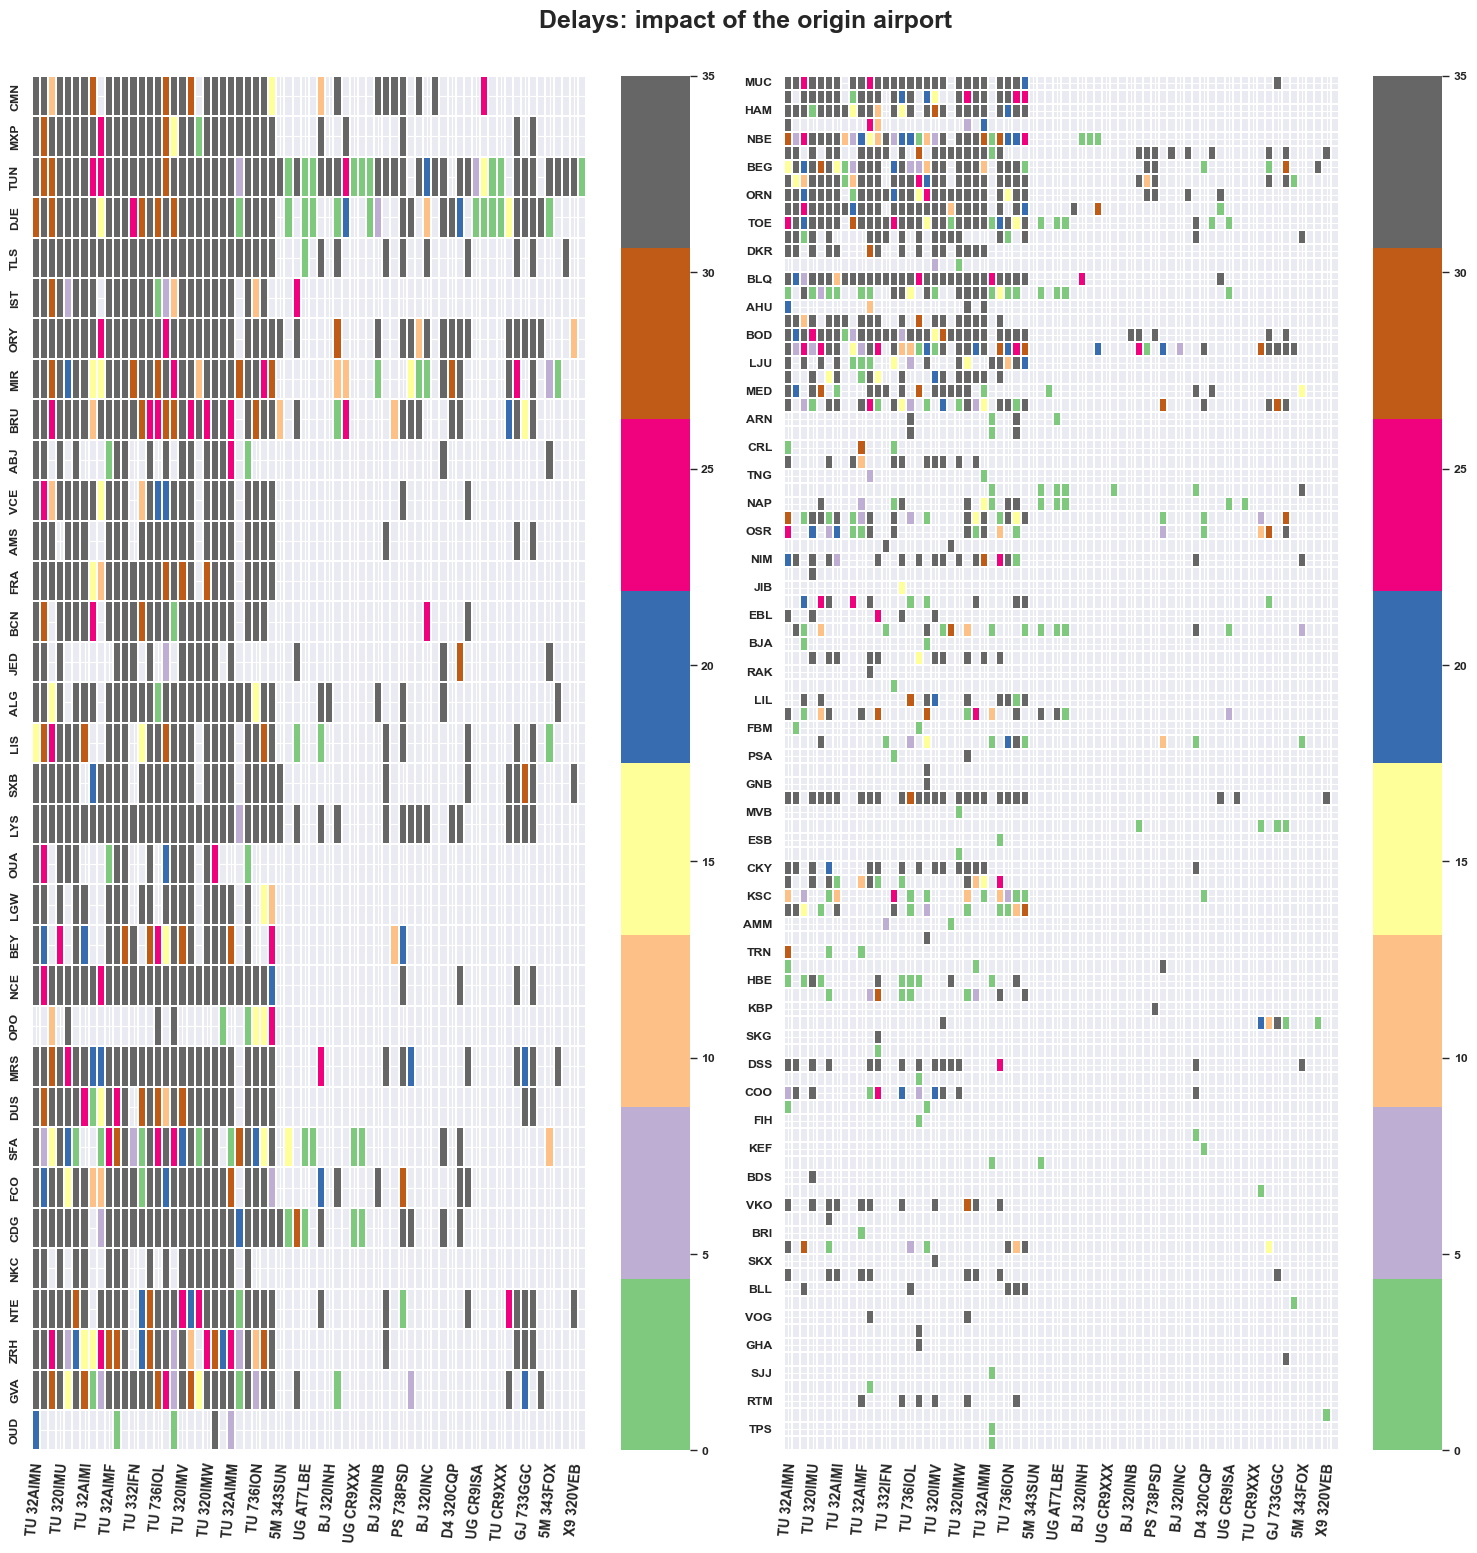

In [114]:
sns.set(context="paper")
fig = plt.figure(1, figsize=(15,15))

ax = fig.add_subplot(1,2,1)
subset = airport_mean_delays.iloc[:34,:]
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)
ax = fig.add_subplot(1,2,2)
subset = airport_mean_delays.iloc[34:,:]
fig.text(0.5, 1.02, "Delays: impact of the origin airport", ha='center', fontsize = 18)
mask = subset.isnull()
sns.heatmap(subset, linewidths=0.01, cmap="Accent", mask=mask, vmin = 0, vmax = 35)
plt.setp(ax.get_xticklabels(), fontsize=10, rotation = 85) ;
ax.yaxis.label.set_visible(False)

plt.tight_layout()

The departure airport has a great impact on the delay we can see the dominance of large delays in a lot of airports like LYS and SXB in the left panel

# Feature Engineering


In [115]:
df['trajectory'] = df['DEPSTN'] + '-' + df['ARRSTN']
df_test['trajectory'] = df_test['DEPSTN'] + '-' + df_test['ARRSTN']

In [116]:
df['trajectory'].nunique()


741

In [117]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  DELAY_LEVEL  year  \
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0            2  2016   
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0            1  2016   
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0            0  2016   
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0            0  2016   
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0            1  2016   

   ac_frequency trajectory  
0             2    CMN-TUN  
1             2    MXP-TUN  
2             2    TUN-IST  
3             2    DJE-NTE  
4             2    TUN-ALG

### Adding day, day of week, month, year and week of the year features

In [118]:
df['month'] = pd.DatetimeIndex(df['DATOP']).month
df['day'] = pd.DatetimeIndex(df['DATOP']).day
df['day_of_week'] = pd.DatetimeIndex(df['DATOP']).dayofweek
df['year'] = pd.DatetimeIndex(df['DATOP']).year
df['week_of_year'] = pd.DatetimeIndex(df['DATOP']).strftime('%U').astype(int)
df_test['month'] = pd.DatetimeIndex(df_test['DATOP']).month
df_test['day'] = pd.DatetimeIndex(df_test['DATOP']).day
df_test['day_of_week'] = pd.DatetimeIndex(df_test['DATOP']).dayofweek
df_test['year'] = pd.DatetimeIndex(df_test['DATOP']).year
df_test['week_of_year'] = pd.DatetimeIndex(df_test['DATOP']).strftime('%U').astype(int)

### Adding a week of month feature

In [119]:

data = [df, df_test]
for dataset in data:
    dataset.loc[ dataset['day'] <= 7, 'week_of_month'] = 0
    dataset.loc[(dataset['day'] > 7) & (dataset['day'] <= 14), 'week_of_month'] = 1
    dataset.loc[(dataset['day'] > 14) & (dataset['day'] <= 21), 'week_of_month'] = 2
    dataset.loc[(dataset['day'] > 21) & (dataset['day'] <= 28), 'week_of_month'] = 3
    dataset.loc[(dataset['day'] > 28) & (dataset['day'] <= 31), 'week_of_month'] = 4
    dataset['week_of_month'] = dataset['week_of_month'].astype(int)

### Adding a season feature


In [120]:
data = [df, df_test]
for dataset in data:
    dataset.loc[ (dataset['month'] < 3) | (dataset['month'] == 12), 'season'] = 0
    dataset.loc[(dataset['month'] >= 3) & (dataset['month'] < 6), 'season'] = 1
    dataset.loc[(dataset['month'] >= 6) & (dataset['month'] < 9), 'season'] = 2
    dataset.loc[(dataset['month'] >= 9) & (dataset['month'] < 12), 'season'] = 3
    dataset['season'] = dataset['season'].astype(int)

### Adding hour of dep and hour of arrive feature


In [121]:
df['dep_hour'] = pd.DatetimeIndex(df['STD']).hour 
df_test['dep_hour'] = pd.DatetimeIndex(df_test['STD']).hour


df['arr_hour'] = pd.DatetimeIndex(df['STA']).hour 
df_test['arr_hour'] = pd.DatetimeIndex(df_test['STA']).hour

### Adding minute of dep and minute of arrive feature


In [122]:
df['dep_minute'] = pd.DatetimeIndex(df['STD']).minute
df_test['dep_minute'] = pd.DatetimeIndex(df_test['STD']).minute

df['arr_minute'] = pd.DatetimeIndex(df['STA']).minute 
df_test['arr_minute'] = pd.DatetimeIndex(df_test['STA']).minute

### Adding flight duration (s,m and h)  feature

In [123]:
df['flight_duration_sec'] = (df['STA'] - df['STD']).values.astype(np.int64) // 10 ** 9
df_test['flight_duration_sec'] = (df_test['STA'] - df_test['STD']).values.astype(np.int64) // 10 ** 9

In [124]:
df['flight_duration_hours'] = df['arr_hour'] - df['dep_hour'] 
df_test['flight_duration_hours'] = df_test['arr_hour'] - df_test['dep_hour']

df['flight_duration_minutes'] = (df['flight_duration_sec'] / 60).astype(np.int64)
df_test['flight_duration_minutes'] = (df_test['flight_duration_sec'] / 60).astype(np.int64)

In [125]:
data = [df, df_test]
for dataset in data:
    dataset.loc[ (dataset['dep_hour'] < 12) , 'dep_hour_AM_PM'] = 0
    dataset.loc[(dataset['dep_hour'] >= 12) , 'dep_hour_AM_PM'] = 1
    dataset['dep_hour_AM_PM'] = dataset['dep_hour_AM_PM'].astype(int)

    dataset.loc[ (dataset['arr_hour'] < 12) , 'arr_hour_AM_PM'] = 0
    dataset.loc[(dataset['arr_hour'] >= 12) , 'arr_hour_AM_PM'] = 1
    dataset['arr_hour_AM_PM'] = dataset['arr_hour_AM_PM'].astype(int)

In [126]:
df['S_dep_hour'] = np.sin(2*np.pi*df['dep_hour']/24)
df['C_dep_hour'] = np.cos(2*np.pi*df['dep_hour']/24)
df_test['S_dep_hour'] = np.sin(2*np.pi*df_test['dep_hour']/24)
df_test['C_dep_hour'] = np.cos(2*np.pi*df_test['dep_hour']/24)


df['S_arr_hour'] = np.sin(2*np.pi*df['arr_hour']/24)
df['C_arr_hour'] = np.cos(2*np.pi*df['arr_hour']/24)
df_test['S_arr_hour'] = np.sin(2*np.pi*df_test['arr_hour']/24)
df_test['C_arr_hour'] = np.cos(2*np.pi*df_test['arr_hour']/24)

In [127]:
data = [df, df_test]
for dataset in data:
    for i in range(dataset.shape[0]):
        dataset.loc[i, 'day_of_year'] = int(dataset.loc[i, 'DATOP'].strftime('%j'))

In [128]:
df.head()

ID      DATOP    FLTID DEPSTN ARRSTN                 STD  \
0  train_id_0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00   
1  train_id_1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00   
2  train_id_2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00   
3  train_id_3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00   
4  train_id_4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00   

                  STA STATUS         AC  target  ...  flight_duration_sec  \
0 2016-01-03 12:55:00    ATA  TU 32AIMN   260.0  ...                 8700   
1 2016-01-13 16:55:00    ATA  TU 31BIMO    20.0  ...                 6600   
2 2016-01-16 06:45:00    ATA  TU 32AIMN     0.0  ...                 9300   
3 2016-01-17 17:00:00    ATA  TU 736IOK     0.0  ...                10200   
4 2016-01-17 15:50:00    ATA  TU 320IMU    22.0  ...                 4800   

   flight_duration_hours  flight_duration_minutes dep_hour_AM_PM  \
0                      2                      145              0   
1                      1                      110              1   
2                      2                      155              0   
3                      3                      170              1   
4                      1                       80              1   

   arr_hour_AM_PM  S_dep_hour  C_dep_hour    S_arr_hour    C_arr_hour  \
0               1    0.500000   -0.866025  1.224647e-16 -1.000000e+00   
1               1   -0.707107   -0.707107 -8.660254e-01 -5.000000e-01   
2               0    0.866025    0.500000  1.000000e+00  6.123234e-17   
3               1   -0.500000   -0.866025 -9.659258e-01 -2.588190e-01   
4               1   -0.500000   -0.866025 -7.071068e-01 -7.071068e-01   

   day_of_year  
0          3.0  
1         13.0  
2         16.0  
3         17.0  
4         17.0  

[5 rows x 34 columns]

In [129]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107833 entries, 0 to 107832
Data columns (total 34 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   ID                       107833 non-null  object        
 1   DATOP                    107833 non-null  datetime64[ns]
 2   FLTID                    107833 non-null  object        
 3   DEPSTN                   107833 non-null  object        
 4   ARRSTN                   107833 non-null  object        
 5   STD                      107833 non-null  datetime64[ns]
 6   STA                      107833 non-null  datetime64[ns]
 7   STATUS                   107833 non-null  object        
 8   AC                       107833 non-null  object        
 9   target                   107833 non-null  float64       
 10  DELAY_LEVEL              107833 non-null  int64         
 11  year                     107833 non-null  int64         
 12  ac_frequency    

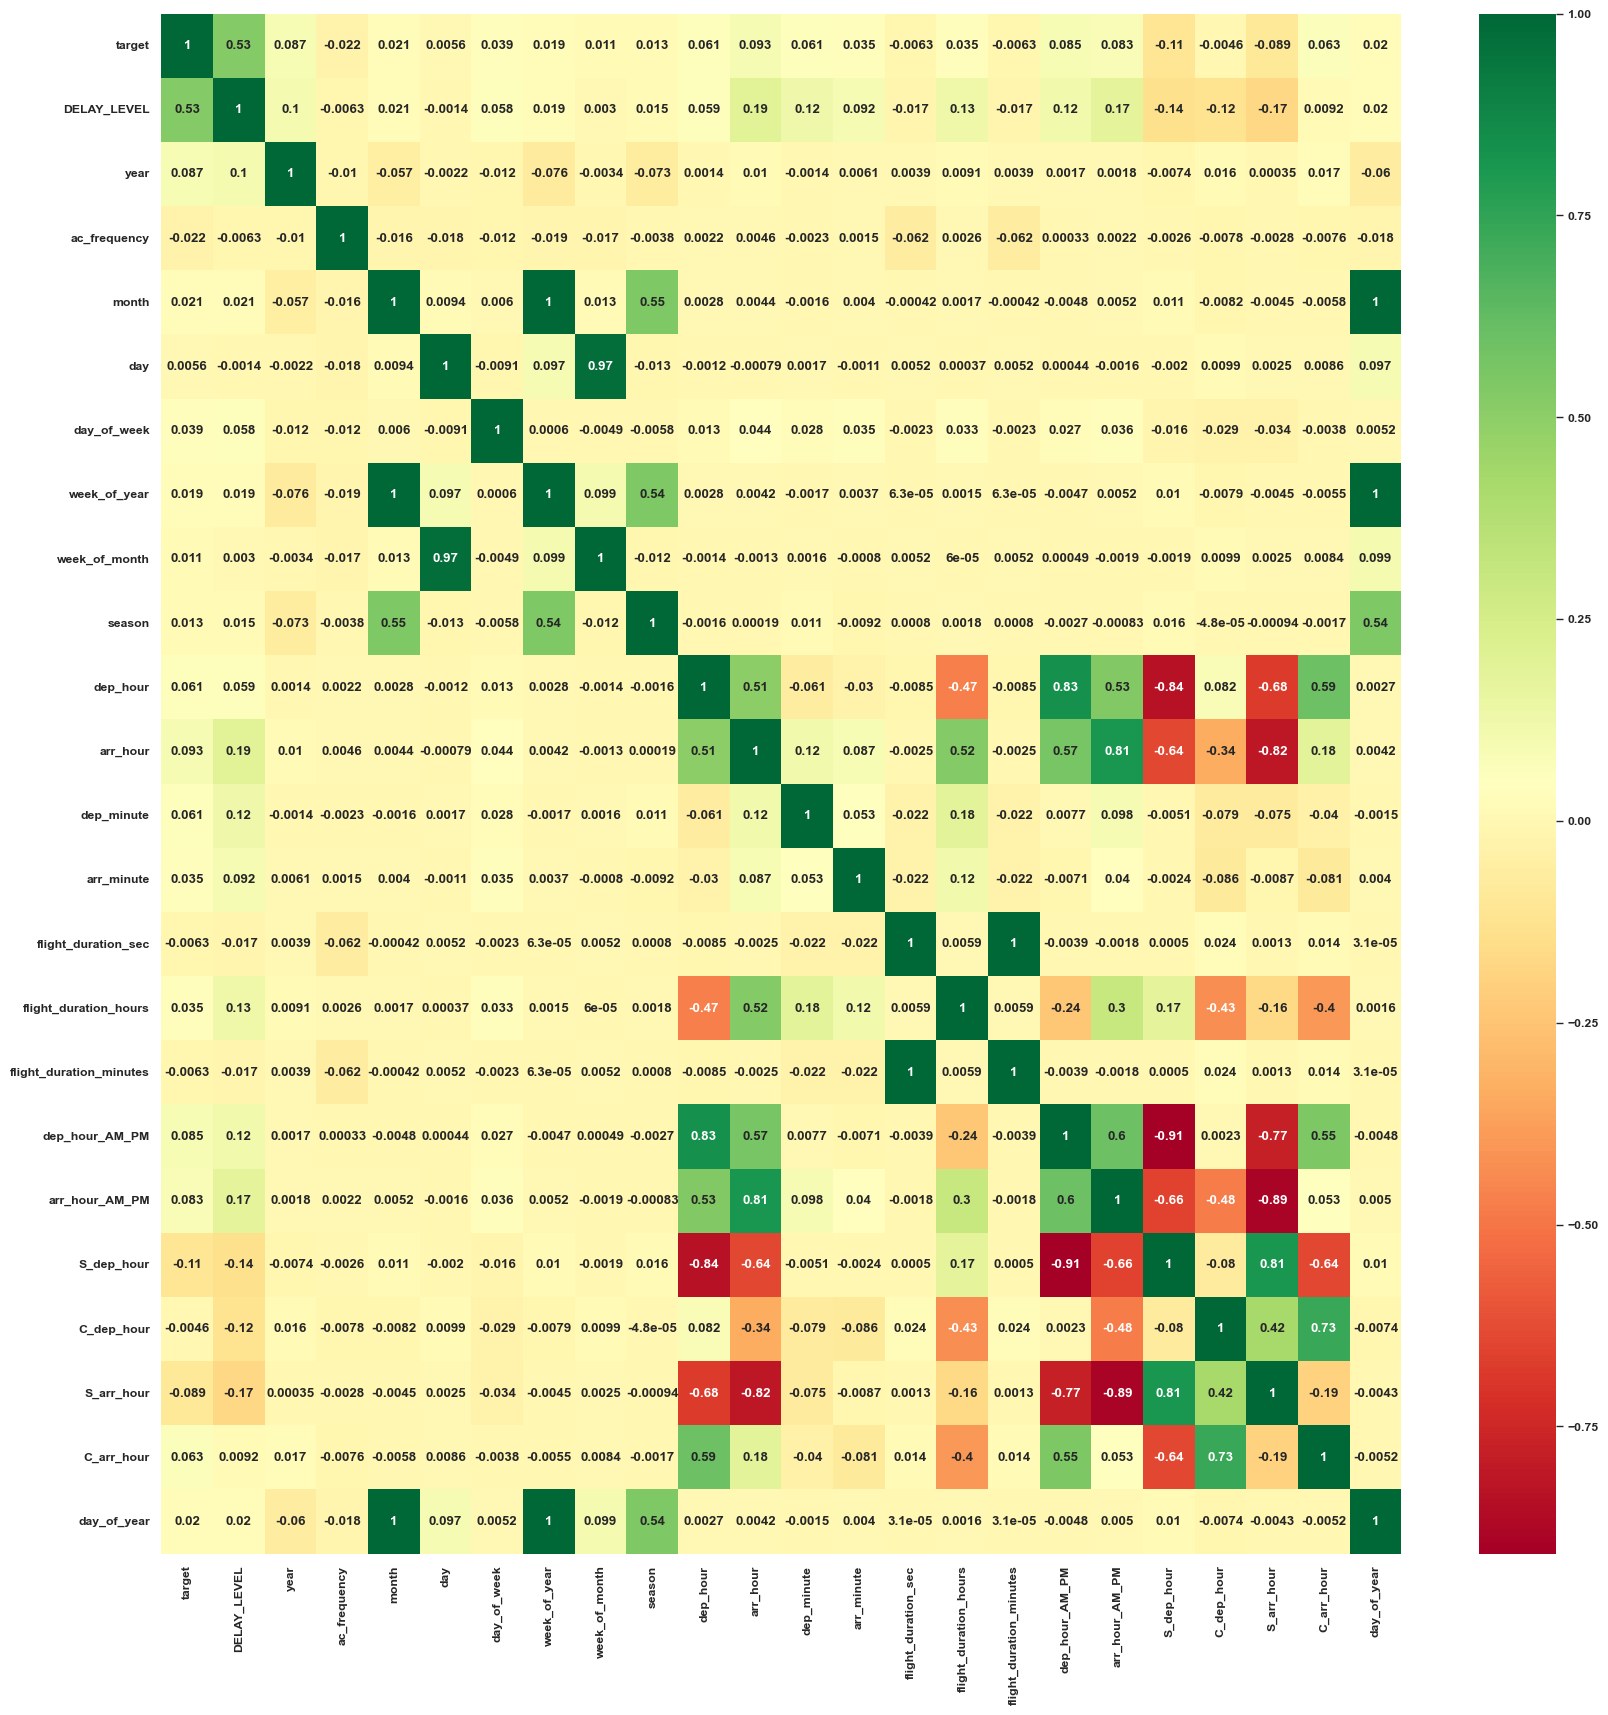

In [130]:
# Select only numeric columns
numeric_columns = df.select_dtypes(include=np.number)

# Calculate correlation matrix
corrmat = numeric_columns.corr()
top_corr_features = corrmat.index

plt.figure(figsize=(20, 20))
# Plot heatmap
g = sns.heatmap(numeric_columns[top_corr_features].corr(), annot=True, cmap="RdYlGn")
plt.show()


# Model

In [131]:
train_cols = ['DATOP', 'FLTID', 'DEPSTN', 'ARRSTN', 'STD', 'STA', 'STATUS',
       'AC', 'trajectory', 'month', 'day', 'day_of_week', 'year',
       'week_of_year', 'week_of_month', 'season', 'dep_hour', 'arr_hour',
       'dep_minute', 'arr_minute', 'flight_duration_sec',
       'flight_duration_hours', 'flight_duration_minutes', 'dep_hour_AM_PM',
       'arr_hour_AM_PM', 'S_dep_hour', 'C_dep_hour', 'S_arr_hour',
       'C_arr_hour', 'day_of_year']
X = df[train_cols]
test = df_test[train_cols]
y = df['target']

In [132]:
X.head()


DATOP    FLTID DEPSTN ARRSTN                 STD                 STA  \
0 2016-01-03  TU 0712    CMN    TUN 2016-01-03 10:30:00 2016-01-03 12:55:00   
1 2016-01-13  TU 0757    MXP    TUN 2016-01-13 15:05:00 2016-01-13 16:55:00   
2 2016-01-16  TU 0214    TUN    IST 2016-01-16 04:10:00 2016-01-16 06:45:00   
3 2016-01-17  TU 0480    DJE    NTE 2016-01-17 14:10:00 2016-01-17 17:00:00   
4 2016-01-17  TU 0338    TUN    ALG 2016-01-17 14:30:00 2016-01-17 15:50:00   

  STATUS         AC trajectory  month  ...  flight_duration_sec  \
0    ATA  TU 32AIMN    CMN-TUN      1  ...                 8700   
1    ATA  TU 31BIMO    MXP-TUN      1  ...                 6600   
2    ATA  TU 32AIMN    TUN-IST      1  ...                 9300   
3    ATA  TU 736IOK    DJE-NTE      1  ...                10200   
4    ATA  TU 320IMU    TUN-ALG      1  ...                 4800   

   flight_duration_hours  flight_duration_minutes  dep_hour_AM_PM  \
0                      2                      145               0   
1                      1                      110               1   
2                      2                      155               0   
3                      3                      170               1   
4                      1                       80               1   

   arr_hour_AM_PM  S_dep_hour  C_dep_hour    S_arr_hour    C_arr_hour  \
0               1    0.500000   -0.866025  1.224647e-16 -1.000000e+00   
1               1   -0.707107   -0.707107 -8.660254e-01 -5.000000e-01   
2               0    0.866025    0.500000  1.000000e+00  6.123234e-17   
3               1   -0.500000   -0.866025 -9.659258e-01 -2.588190e-01   
4               1   -0.500000   -0.866025 -7.071068e-01 -7.071068e-01   

   day_of_year  
0          3.0  
1         13.0  
2         16.0  
3         17.0  
4         17.0  

[5 rows x 30 columns]

In [133]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1,random_state=17)


In [134]:
categ_feat_idx = np.where(X_train.dtypes == 'object')[0]
categ_feat_idx

array([1, 2, 3, 6, 7, 8])

## Catboost

In [135]:
model = CatBoostRegressor(iterations=699, depth=10, learning_rate=0.1,l2_leaf_reg= 7, loss_function='RMSE')
model.fit(X_train, y_train,cat_features=categ_feat_idx,eval_set=(X_test, y_test),plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 116.3089674	test: 114.9300981	best: 114.9300981 (0)	total: 75.2ms	remaining: 52.5s
1:	learn: 115.5961271	test: 114.2514472	best: 114.2514472 (1)	total: 136ms	remaining: 47.4s
2:	learn: 114.9543742	test: 113.6409514	best: 113.6409514 (2)	total: 189ms	remaining: 43.9s
3:	learn: 114.3723712	test: 113.1248214	best: 113.1248214 (3)	total: 261ms	remaining: 45.4s
4:	learn: 113.9267304	test: 112.7302427	best: 112.7302427 (4)	total: 338ms	remaining: 46.9s
5:	learn: 113.4883607	test: 112.3270335	best: 112.3270335 (5)	total: 409ms	remaining: 47.2s
6:	learn: 113.1674621	test: 112.0421914	best: 112.0421914 (6)	total: 472ms	remaining: 46.6s
7:	learn: 112.7642986	test: 111.7381900	best: 111.7381900 (7)	total: 560ms	remaining: 48.4s
8:	learn: 112.4738406	test: 111.5071050	best: 111.5071050 (8)	total: 696ms	remaining: 53.4s
9:	learn: 112.1485901	test: 111.2876121	best: 111.2876121 (9)	total: 814ms	remaining: 56.1s
10:	learn: 111.8752930	test: 111.0645799	best: 111.0645799 (10)	total: 925ms	re

In [136]:
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score


In [137]:
predictions = model.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,predictions))
print(rmse)
r2 = r2_score(y_test, predictions)
print(r2)


104.48439217727788
0.18752066259188915


In [138]:
model = CatBoostRegressor()
parameters = {'depth'         : [6,8],
              'learning_rate' : [0.01, 0.05],
              'iterations'    : [650, 700]
             }
grid = GridSearchCV(estimator=model, param_grid = parameters, cv = 2, n_jobs=-1)
grid.fit(X_train, y_train,cat_features=categ_feat_idx,eval_set=(X_test, y_test))    
print(grid.param_grid)
# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n",
      grid.best_estimator_)

print("\n The best score across ALL searched params:\n",
      grid.best_score_)

print("\n The best parameters across ALL searched params:\n",
      grid.best_params_)

0:	learn: 118.4914289	test: 115.8449029	best: 115.8449029 (0)	total: 227ms	remaining: 2m 27s
0:	learn: 115.8825191	test: 115.8456836	best: 115.8456836 (0)	total: 273ms	remaining: 2m 57s
0:	learn: 115.5969691	test: 115.5691772	best: 115.5691772 (0)	total: 244ms	remaining: 2m 38s
1:	learn: 118.4196688	test: 115.7736317	best: 115.7736317 (1)	total: 376ms	remaining: 2m 1s
1:	learn: 115.8108552	test: 115.7792806	best: 115.7792806 (1)	total: 433ms	remaining: 2m 20s
1:	learn: 115.2679892	test: 115.2658301	best: 115.2658301 (1)	total: 427ms	remaining: 2m 18s
2:	learn: 115.7417972	test: 115.7133480	best: 115.7133480 (2)	total: 610ms	remaining: 2m 11s
2:	learn: 118.3452414	test: 115.7010414	best: 115.7010414 (2)	total: 620ms	remaining: 2m 13s
2:	learn: 114.9384590	test: 114.9380731	best: 114.9380731 (2)	total: 583ms	remaining: 2m 5s
0:	learn: 118.1970170	test: 115.5501753	best: 115.5501753 (0)	total: 367ms	remaining: 3m 58s
3:	learn: 115.6759008	test: 115.6498484	best: 115.6498484 (3)	total: 782

In [139]:
best_params = grid.best_params_

modelCat2 = CatBoostRegressor(**best_params)
modelCat2.fit(X_train, y_train, cat_features=categ_feat_idx, eval_set=(X_test, y_test), plot=True)


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 116.8292710	test: 115.4686886	best: 115.4686886 (0)	total: 51.8ms	remaining: 36.2s
1:	learn: 116.4471194	test: 115.1059559	best: 115.1059559 (1)	total: 99.4ms	remaining: 34.7s
2:	learn: 116.1014627	test: 114.7595171	best: 114.7595171 (2)	total: 149ms	remaining: 34.6s
3:	learn: 115.7872408	test: 114.4623560	best: 114.4623560 (3)	total: 206ms	remaining: 35.9s
4:	learn: 115.4901678	test: 114.1836916	best: 114.1836916 (4)	total: 264ms	remaining: 36.8s
5:	learn: 115.2490020	test: 113.9515657	best: 113.9515657 (5)	total: 309ms	remaining: 35.8s
6:	learn: 114.9814819	test: 113.6803147	best: 113.6803147 (6)	total: 360ms	remaining: 35.6s
7:	learn: 114.7343074	test: 113.4429490	best: 113.4429490 (7)	total: 432ms	remaining: 37.3s
8:	learn: 114.5255116	test: 113.2425979	best: 113.2425979 (8)	total: 510ms	remaining: 39.2s
9:	learn: 114.3504403	test: 113.0733677	best: 113.0733677 (9)	total: 566ms	remaining: 39.1s
10:	learn: 114.1826668	test: 112.9224316	best: 112.9224316 (10)	total: 625ms	r

In [140]:
predictions2 = modelCat2.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,predictions2))
print(rmse)

105.94101476898852


## LinearRegression

In [141]:
## LinearRegression
one_hot = pd.get_dummies(X['STATUS'])
X = X.drop('STATUS',axis = 1)
X = X.join(one_hot)
one_hot = pd.get_dummies(test['STATUS'])
test = test.drop('STATUS',axis = 1)
test = test.join(one_hot)
le = LabelEncoder()
# enc = OneHotEncoder(sparse=False)
X['DEPSTN'] = le.fit_transform(X['DEPSTN'])
X['ARRSTN'] = le.fit_transform(X['ARRSTN'])
X['AC'] = le.fit_transform(X['AC'])
X['FLTID'] = le.fit_transform(X['FLTID'])
X['trajectory'] = le.fit_transform(X['trajectory'])
test['DEPSTN'] = le.fit_transform(test['DEPSTN'])
test['ARRSTN'] = le.fit_transform(test['ARRSTN'])
test['AC'] = le.fit_transform(test['AC'])
test['FLTID'] = le.fit_transform(test['FLTID'])
test['trajectory'] = le.fit_transform(test['trajectory'])
X.head()

X['DATOP_ts'] = X.DATOP.values.astype(np.int64) // 10 ** 9
X['STD_ts'] = X.STD.values.astype(np.int64) // 10 ** 9
X['STA_ts'] = X.STA.values.astype(np.int64) // 10 ** 9
del X['DATOP']
del X['STA']
del X['STD']
test['DATOP_ts'] = test.DATOP.values.astype(np.int64) // 10 ** 9
test['STD_ts'] = test.STD.values.astype(np.int64) // 10 ** 9
test['STA_ts'] = test.STA.values.astype(np.int64) // 10 ** 9
del test['DATOP']
del test['STA']
del test['STD']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=17)

modelLR = linear_model.LinearRegression()
modelLR.fit(X_train, y_train)
results = modelLR.predict(X_test)
score1 = np.sqrt(metrics.mean_squared_error(y_test,results))
score2 = metrics.r2_score(y_test,results )
print('RMSE: ',score1, '  R2 Score: ', score2)

RMSE:  112.93358434735914   R2 Score:  0.056151253636970155


## XGBRegressor

In [142]:
! pip3 install xgboost


[notice] A new release of pip available: 22.3.1 -> 23.1.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [143]:
from xgboost import XGBRegressor
xgboostmodel = XGBRegressor(learning_rate=0.05, n_estimators=800, max_depth=4)
eval_set = [(X_test,y_test)]
xgboostmodel.fit(X_train,y_train, eval_set = eval_set, eval_metric = "rmse", verbose = 30, early_stopping_rounds=300)

[0]	validation_0-rmse:124.62869


/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.

/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning:

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.



[30]	validation_0-rmse:112.51553
[60]	validation_0-rmse:110.72118
[90]	validation_0-rmse:109.94330
[120]	validation_0-rmse:109.38530
[150]	validation_0-rmse:109.06037
[180]	validation_0-rmse:108.85574
[210]	validation_0-rmse:108.61001
[240]	validation_0-rmse:108.29587
[270]	validation_0-rmse:108.17579
[300]	validation_0-rmse:107.99136
[330]	validation_0-rmse:107.86882
[360]	validation_0-rmse:107.77807
[390]	validation_0-rmse:107.67174
[420]	validation_0-rmse:107.56399
[450]	validation_0-rmse:107.50380
[480]	validation_0-rmse:107.43553
[510]	validation_0-rmse:107.37641
[540]	validation_0-rmse:107.28673
[570]	validation_0-rmse:107.19771
[600]	validation_0-rmse:107.14294
[630]	validation_0-rmse:107.05844
[660]	validation_0-rmse:107.00357
[690]	validation_0-rmse:106.86578
[720]	validation_0-rmse:106.87282
[750]	validation_0-rmse:106.84928
[780]	validation_0-rmse:106.82995
[799]	validation_0-rmse:106.82124


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=800, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [144]:
xgboostmodel_prediction = xgboostmodel.predict(X_test)


In [145]:
MSE = metrics.mean_squared_error(y_test, xgboostmodel_prediction)
MSE

11409.676940542662

In [146]:
np.sqrt(MSE)

106.81608933368915

In [147]:
model = XGBRegressor()
parameters = {'max_depth': [6, 8],
              'learning_rate': [0.01, 0.05],
              'n_estimators': [650, 700]
             }

grid = GridSearchCV(estimator=model, param_grid=parameters, cv=2, n_jobs=-1)
grid.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=10, verbose=False)

# Results from Grid Search
print("\n========================================================")
print(" Results from Grid Search ")
print("========================================================")

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)
print("\n The best score across ALL searched params:\n", grid.best_score_)
print("\n The best parameters across ALL searched params:\n", grid.best_params_)

/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in const


 Results from Grid Search 

 The best estimator across ALL searched params:
 XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=650, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

 The best score across ALL searched params:
 0.12793235813452358

 The best parameters across ALL searched params:
 {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 650}


In [148]:
best_params = grid.best_params_

xgboostmodel2 = XGBRegressor(**best_params)
xgboostmodel2.fit(X_train,y_train, eval_set = eval_set, eval_metric = "rmse", verbose = 30, early_stopping_rounds=300)

[0]	validation_0-rmse:124.48596


/opt/homebrew/lib/python3.11/site-packages/xgboost/sklearn.py:835: UserWarning:

`eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.



[30]	validation_0-rmse:110.45908
[60]	validation_0-rmse:107.35860
[90]	validation_0-rmse:106.38046
[120]	validation_0-rmse:105.83916
[150]	validation_0-rmse:105.51050
[180]	validation_0-rmse:105.21153
[210]	validation_0-rmse:104.90648
[240]	validation_0-rmse:104.46514
[270]	validation_0-rmse:104.24927
[300]	validation_0-rmse:104.05552
[330]	validation_0-rmse:103.95140
[360]	validation_0-rmse:103.95451
[390]	validation_0-rmse:103.89126
[420]	validation_0-rmse:103.75925
[450]	validation_0-rmse:103.69021
[480]	validation_0-rmse:103.66751
[510]	validation_0-rmse:103.62518
[540]	validation_0-rmse:103.59412
[570]	validation_0-rmse:103.58141
[600]	validation_0-rmse:103.57350
[630]	validation_0-rmse:103.54454
[649]	validation_0-rmse:103.54129


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=650, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [149]:
xgboostmodel_prediction2 = xgboostmodel2.predict(X_test)
rmse = sqrt(mean_squared_error(y_test,xgboostmodel_prediction2))
print(rmse)

103.52582085873391


# Save model

In [150]:
import joblib
prediction_model = 'finalized_model.sav'
joblib.dump(xgboostmodel_prediction2, prediction_model)


['finalized_model.sav']